# 1. Import libraries

In [122]:
# Impor library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Set style untuk visualisasi
sns.set(style="whitegrid")

In [ ]:
# generate syntethic data

# Membuat Dataset sintetik

In [ ]:
import pandas as pd
import numpy as np

# 1. Buat rentang tanggal dari 2023-03-01 hingga 2025-03-10
dates = pd.date_range(start='2023-03-01', end='2025-03-10', freq='D')
df = pd.DataFrame({'Tanggal': dates})

# 2. Buat penjualan tiket dasar (misal rata-rata 50.000 tiket per hari) ditambah noise acak
np.random.seed(42)  # agar hasil random konsisten
base_sales = 50000 + np.random.normal(0, 5000, len(dates))
df['ticket_sales'] = base_sales

# 3. Fungsi untuk menentukan apakah suatu tanggal termasuk periode event (mudik)
def is_event(date):
    year = date.year
    # Untuk tahun 2023 dan 2024, periode event didefinisikan dari 20 Maret hingga 5 April.
    if year in [2023, 2024]:
        start_event = pd.Timestamp(year=year, month=3, day=20)
        end_event = pd.Timestamp(year=year, month=4, day=5)
        if start_event <= date <= end_event:
            return True
    return False

# 4. Terapkan lonjakan penjualan selama event (misal naik 40%)
event_mask = df['Tanggal'].apply(is_event)
df.loc[event_mask, 'ticket_sales'] *= 1.4

# 5. Konversi nilai penjualan tiket menjadi integer
df['ticket_sales'] = df['ticket_sales'].astype(int)

# Tampilkan beberapa baris pertama
print(df.head(15))
print(df.tail(15))

# Opsional: Simpan dataset ke file CSV
df.to_csv('synthetic_train_ticket_sales.csv', index=False)


# 2. Create Simulation Dataset

In [ ]:

# Buat DataFrame simulasi
df = pd.read_csv("synthetic_train_ticket_sales.csv",)
df.rename(columns={'Tanggal': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Tampilkan 5 baris pertama
print("Contoh 5 baris pertama dataset simulasi:")
print(df.head())


Contoh 5 baris pertama dataset simulasi:
        Date  ticket_sales
0 2023-03-01         52483
1 2023-03-02         49308
2 2023-03-03         53238
3 2023-03-04         57615
4 2023-03-05         48829


In [136]:
import pandas as pd

# Misalkan df sudah punya kolom 'Date' bertipe datetime dan 'ticket_sales'
# Pastikan df sudah di-sort berdasarkan 'Date' jika diperlukan
df['Date'] = pd.to_datetime(df['Date'])

def is_mudik_func(date):
    """
    Mengembalikan 1 jika 'date' berada di rentang 20 Maret - 5 April
    (tergantung tahunnya), sebaliknya 0.
    """
    year = date.year
    start_event = pd.Timestamp(year=year, month=3, day=20)
    end_event   = pd.Timestamp(year=year, month=4, day=5)
    if start_event <= date <= end_event:
        return 1
    else:
        return 0

# Membuat kolom is_mudik
df['is_mudik'] = df['Date'].apply(is_mudik_func)



# 3. EDA


Deskripsi Data:
count      741.000000
mean     50853.537112
std       6520.683506
min      33793.000000
25%      46741.000000
50%      50321.000000
75%      53716.000000
max      83133.000000
Name: ticket_sales, dtype: float64


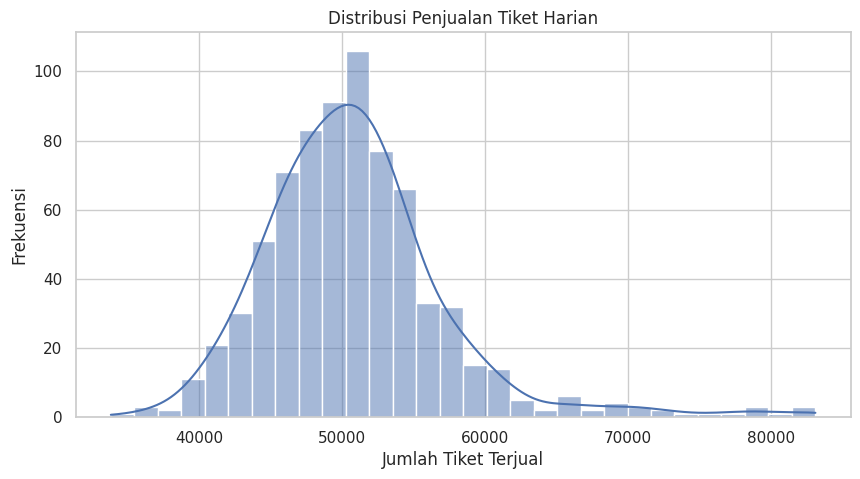

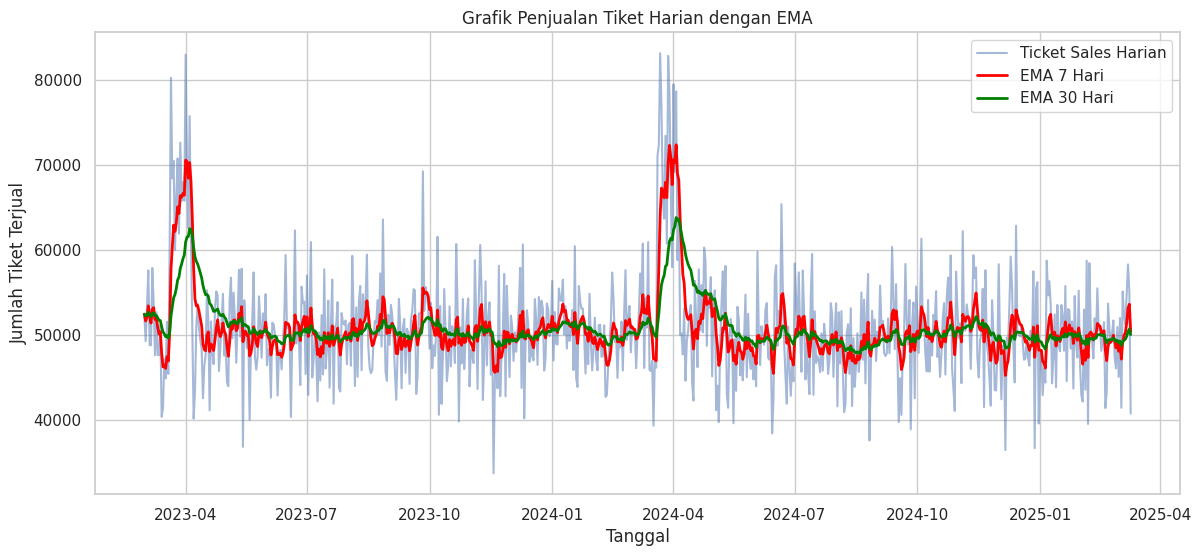

In [137]:
# Ringkasan statistik
print("\nDeskripsi Data:")
print(df['ticket_sales'].describe())

# Visualisasi distribusi penjualan tiket harian
plt.figure(figsize=(10,5))
sns.histplot(df['ticket_sales'], bins=30, kde=True)
plt.title("Distribusi Penjualan Tiket Harian")
plt.xlabel("Jumlah Tiket Terjual")
plt.ylabel("Frekuensi")
plt.show()
#---MA ---
# Menghitung EMA dengan span 7 hari dan 30 hari
df['EMA_7'] = df['ticket_sales'].ewm(span=7, adjust=False).mean()
df['EMA_30'] = df['ticket_sales'].ewm(span=30, adjust=False).mean()

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['ticket_sales'], label="Ticket Sales Harian", alpha=0.5)
plt.plot(df['Date'], df['EMA_7'], label="EMA 7 Hari", color='red', linewidth=2)
plt.plot(df['Date'], df['EMA_30'], label="EMA 30 Hari", color='green', linewidth=2)
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Tiket Terjual")
plt.title("Grafik Penjualan Tiket Harian dengan EMA")
plt.legend()
plt.grid(True)
plt.show()


# 4. Feature Engineering
1. Membuat lag feature 1 dan 7 hari untuk passing informasi berdasarkan hari sebelumnya
2. membuat fourier feature untuk menggambarkan seasonality.
3. Is holiday bisa dijadikan opsi yang sangat menarik dan event event lainnya.


Contoh data setelah feature engineering:
        Date  ticket_sales         EMA_7        EMA_30  day_of_week  month  \
0 2023-03-15         41375  46280.757769  50381.515842            2      3   
1 2023-03-16         47188  46507.568326  50175.482562            3      3   
2 2023-03-17         44935  46114.426245  49837.386913            4      3   
3 2023-03-18         51571  47478.569684  49949.232918            5      3   
4 2023-03-19         45459  46973.677263  49659.540472            6      3   
5 2023-03-20         60113  50258.507947  50333.957216            0      3   
6 2023-03-21         80259  57758.630960  52264.605137            1      3   
7 2023-03-22         68419  60423.723220  53306.824161            2      3   
8 2023-03-23         70472  62935.792415  54414.254860            3      3   
9 2023-03-24         60026  62208.344311  54776.302934            4      3   

   day_of_year  week_of_year    lag_1    lag_7   lag_14  is_mudik  
0           74            11  4

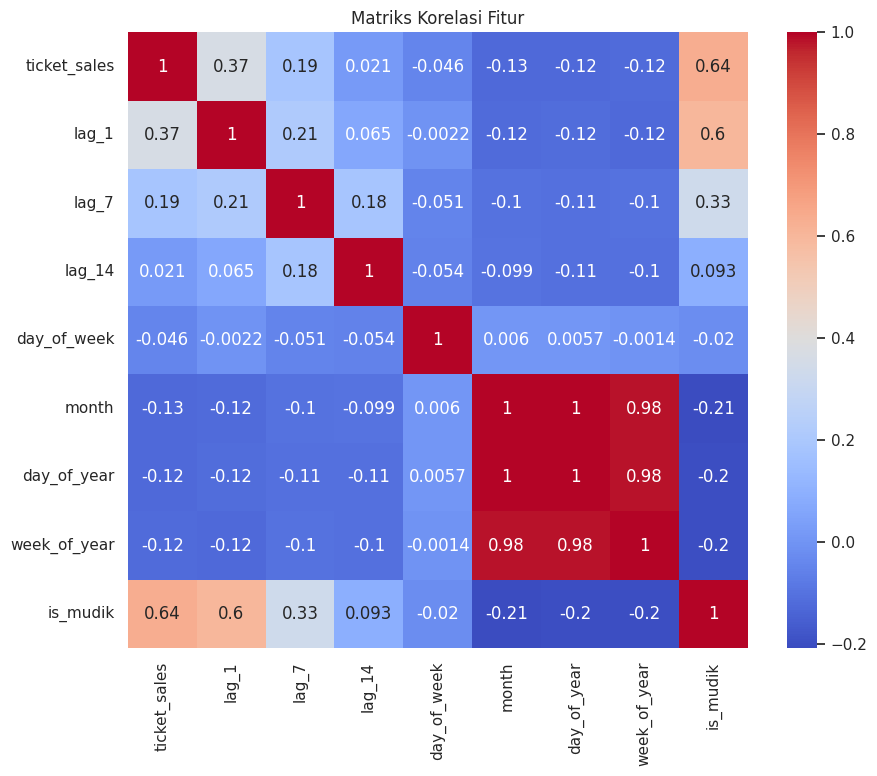

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsi df sudah memiliki kolom 'Date' dan 'ticket_sales'

# 1. Fitur Waktu Dasar
df['day_of_week'] = df['Date'].dt.dayofweek       # Senin=0, Minggu=6
df['month'] = df['Date'].dt.month
df['day_of_year'] = df['Date'].dt.dayofyear
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

# 2. Lag Features: lag 1, lag 7, dan lag 14 hari
df['lag_1'] = df['ticket_sales'].shift(1)
df['lag_7'] = df['ticket_sales'].shift(7)
df['lag_14'] = df['ticket_sales'].shift(14)


# 4. Hapus baris yang memiliki nilai NaN (akibat lag features)
df_model = df.dropna().reset_index(drop=True)

print("\nContoh data setelah feature engineering:")
print(df_model.head(10))

# 5. Tampilkan korelasi antara fitur dan target
features_for_corr = [
    'ticket_sales', 
    'lag_1', 'lag_7', 'lag_14',
    'day_of_week', 'month', 'day_of_year', 'week_of_year','is_mudik'
]

plt.figure(figsize=(10,8))
sns.heatmap(df_model[features_for_corr].corr(), annot=True, cmap="coolwarm")
plt.title("Matriks Korelasi Fitur")
plt.show()


# 5. Split dataset

In [141]:
# Menentukan fitur dan target
feature_cols = ['lag_1', 'lag_7','lag_14', 'day_of_week', 'month', 'day_of_year',
                 'week_of_year','is_mudik']
X = df_model[feature_cols]
y = df_model['ticket_sales']

# Split data berdasarkan urutan waktu (80% training, 20% test)
split_idx = int(0.8 * len(df_model))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("\nUkuran Training:", X_train.shape)
print("Ukuran Test:", X_test.shape)


Ukuran Training: (581, 8)
Ukuran Test: (146, 8)


# 6. Train and Validation


Evaluasi Model pada Test Set:
MAE: 4531.7710830479455
RMSE: 5694.956804229352


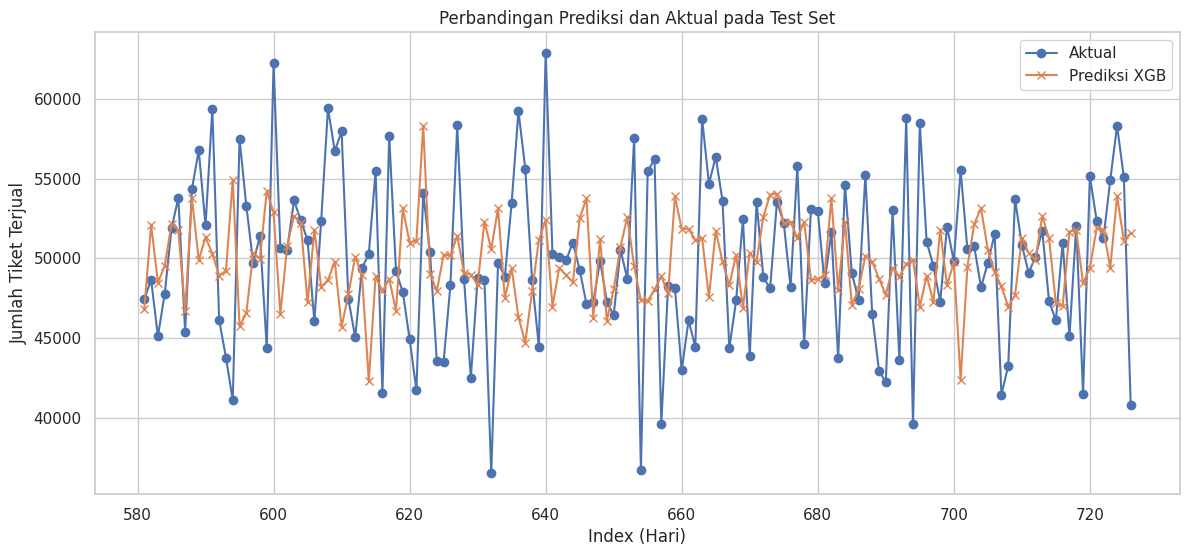

In [190]:
# Melatih model XGBRegressor
from sklearn.linear_model import LinearRegression
model_xgb = XGBRegressor(n_estimators=200,max_depth = 7, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# Prediksi pada test set
y_pred = model_xgb.predict(X_test)

# Evaluasi model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nEvaluasi Model pada Test Set:")
print("MAE:", mae)
print("RMSE:", rmse)

# Visualisasi hasil prediksi vs. data aktual
plt.figure(figsize=(14,6))
plt.plot(X_test.index, y_test, label="Aktual", marker='o')
plt.plot(X_test.index, y_pred, label="Prediksi XGB", marker='x')
plt.xlabel("Index (Hari)")
plt.ylabel("Jumlah Tiket Terjual")
plt.title("Perbandingan Prediksi dan Aktual pada Test Set")
plt.legend()
plt.grid(True)
plt.show()


# 7. Forecast

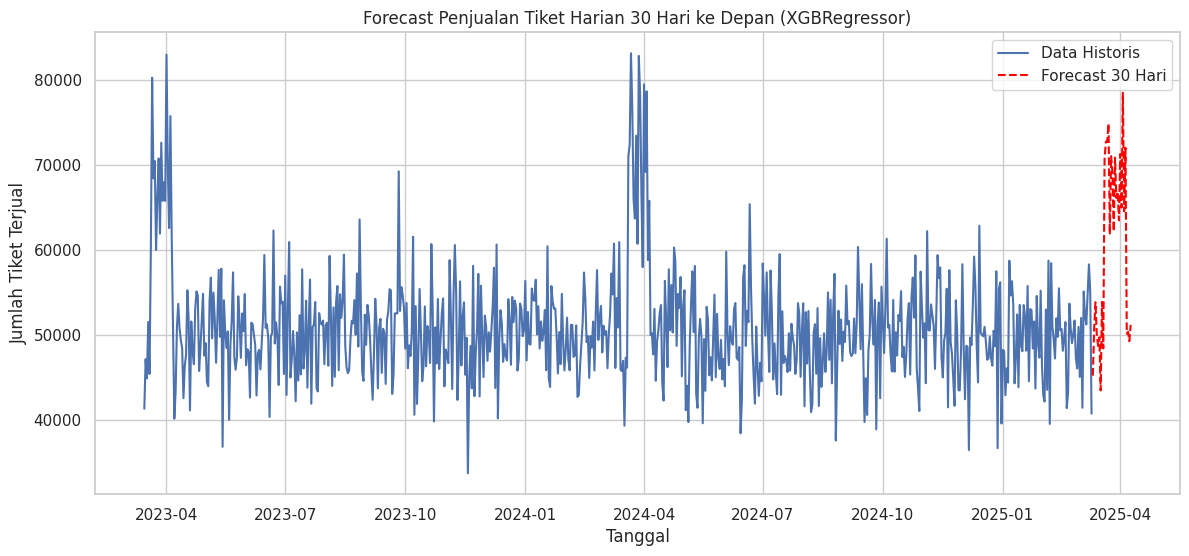

Forecast 30 hari ke depan:
         Date      Forecast
0  2025-03-11  45262.347656
1  2025-03-12  50847.312500
2  2025-03-13  53886.621094
3  2025-03-14  50169.007812
4  2025-03-15  48761.714844
5  2025-03-16  49770.359375
6  2025-03-17  43522.390625
7  2025-03-18  53912.054688
8  2025-03-19  48460.980469
9  2025-03-20  70715.375000
10 2025-03-21  72749.757812
11 2025-03-22  72725.843750
12 2025-03-23  74869.312500
13 2025-03-24  61846.250000
14 2025-03-25  71044.609375
15 2025-03-26  69029.796875
16 2025-03-27  62207.085938
17 2025-03-28  70870.218750
18 2025-03-29  66135.703125
19 2025-03-30  66889.820312
20 2025-03-31  63503.601562
21 2025-04-01  71293.585938
22 2025-04-02  64998.539062
23 2025-04-03  78492.382812
24 2025-04-04  64567.312500
25 2025-04-05  72030.265625
26 2025-04-06  50196.843750
27 2025-04-07  50412.328125
28 2025-04-08  49309.828125
29 2025-04-09  51221.500000


In [188]:
# Forecasting ke depan: 30 hari ke depan
n_future = 30
last_date = df_model['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='D')

# Buat DataFrame untuk data masa depan
df_future = pd.DataFrame({'Date': future_dates})
df_future['day_of_week'] = df_future['Date'].dt.dayofweek
df_future['month'] = df_future['Date'].dt.month
df_future['day_of_year'] = df_future['Date'].dt.day_of_year
df_future['week_of_year'] = df_future['Date'].dt.isocalendar().week.astype(int)
df_future['is_mudik'] = df_future['Date'].apply(is_mudik_func)
# Proses forecasting iteratif:
future_preds = []
# Ambil baris terakhir dari dataset training (data historis)
last_known = df_model.iloc[-1].copy()

for i in range(n_future):
    # Fitur lag: jika prediksi sudah tersedia, gunakan prediksi tersebut; jika belum, ambil dari data historis
    lag_1 = last_known['ticket_sales'] if i == 0 else future_preds[-1]
    if i < 7:
        lag_7 = df_model.iloc[-7 + i]['ticket_sales']
    else:
        lag_7 = future_preds[i-7]
    if i < 14:
        lag_14 = df_model.iloc[-14 + i]['ticket_sales']
    else:
        lag_14 = future_preds[i-14]
        
    # Ambil fitur dari df_future
    row = df_future.iloc[i]
    features = pd.DataFrame({
        'lag_1': [lag_1],
        'lag_7': [lag_7],
        'lag_14':[lag_14],
        'day_of_week': [row['day_of_week']],
        'month': [row['month']],
        'day_of_year': [row['day_of_year']],
        'week_of_year': [row['week_of_year']],
        'is_mudik': [row['is_mudik']]
    })
    pred = model_xgb.predict(features)[0]
    future_preds.append(pred)
    last_known['ticket_sales'] = pred  # Update nilai untuk lag selanjutnya

df_future['Forecast'] = future_preds

# Visualisasi hasil forecast 30 hari ke depan bersama data historis
plt.figure(figsize=(14,6))
plt.plot(df_model['Date'], df_model['ticket_sales'], label="Data Historis")
plt.plot(df_future['Date'], df_future['Forecast'], label="Forecast 30 Hari", linestyle='--', color='red')
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Tiket Terjual")
plt.title("Forecast Penjualan Tiket Harian 30 Hari ke Depan (XGBRegressor)")
plt.legend()
plt.grid(True)
plt.show()

print("Forecast 30 hari ke depan:")
print(df_future[['Date', 'Forecast']])


# Dari prediksi penjualan tiket di atas bisa diperkirakan jumlah armada kereta api yang dibutuhkan.

Dari Hasil prediksi harga tiket, diasumsikan 1 kereta dapat menampung 10000 penumpang, maka minimal kereta yang dibutuhakan adalah $$ \lceil jumlah tiket/1000 \rceil $$


Dengan asumsi tambahan 10% armada untuk berjaga jaga

In [182]:
df_future['Armada'] =(df_future['Forecast'] + 1)/1000 
df_future['Armada'] += df_future['Armada']*10/100

In [183]:
df_future['Armada'] = ((df_future['Armada']+1)).astype(int)

In [184]:
df_future[['Date','Armada']]

,Date,Armada
0,2025-03-11,50
1,2025-03-12,56
2,2025-03-13,60
3,2025-03-14,56
4,2025-03-15,54
5,2025-03-16,55
6,2025-03-17,48
7,2025-03-18,60
8,2025-03-19,54
9,2025-03-20,78
